In [48]:
# ---- Imports -----

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE



from scipy.stats import randint as sp_randint





In [49]:
#lets look at this data to understant what preprocessing needs to happen

df = pd.read_csv("data/ransom_vs_malware.csv")

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18551 entries, 0 to 18550
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SHA256                       18551 non-null  object 
 1   Malware_Type                 18551 non-null  object 
 2   e_magic                      18551 non-null  int64  
 3   e_cblp                       18551 non-null  int64  
 4   e_cp                         18551 non-null  int64  
 5   e_crlc                       18551 non-null  int64  
 6   e_cparhdr                    18551 non-null  int64  
 7   e_minalloc                   18551 non-null  int64  
 8   e_maxalloc                   18551 non-null  int64  
 9   e_ss                         18551 non-null  int64  
 10  e_sp                         18551 non-null  int64  
 11  e_csum                       18551 non-null  int64  
 12  e_ip                         18551 non-null  int64  
 13  e_cs            

In [10]:
df.head()

,SHA256,Malware_Type,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,...,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes
0,011af3a69ca68178ed40d746cb4f6b108b954290afb53d...,Spyware,23117,144,3,0,4,0,65535,0,...,1437696,1024,1443308,3,0,2097152,1048576,4096,0,16
1,011bdb01c6863489c07befe11070e58a2a5b0feffd8be8...,Generic Malware,23117,144,3,0,4,0,65535,0,...,917504,512,0,2,34112,1048576,1048576,4096,0,16
2,e5a8176770ea11671eb417ac3f8b999b18b3d2e2be5557...,Generic Malware,23117,144,3,0,4,0,65535,0,...,139264,512,0,3,34144,1048576,1048576,4096,0,16
3,6500927c19e228cc116484a103ba594fdeadccf0615933...,Ransomware,23117,80,2,0,4,15,65535,0,...,110592,1024,0,2,0,1048576,1048576,4096,0,16
4,03aff1fde2776490687f40a87668e6e8f64d823af23a11...,Spyware,23117,144,3,0,4,0,65535,0,...,425984,1024,435363,2,32768,1048576,1048576,4096,0,16


- Shows no missing values
- Shows 2 columns have non-int values. Will need further processing

array([[<Axes: title={'center': 'e_magic'}>,
        <Axes: title={'center': 'e_cblp'}>,
        <Axes: title={'center': 'e_cp'}>,
        <Axes: title={'center': 'e_crlc'}>,
        <Axes: title={'center': 'e_cparhdr'}>,
        <Axes: title={'center': 'e_minalloc'}>,
        <Axes: title={'center': 'e_maxalloc'}>],
       [<Axes: title={'center': 'e_ss'}>,
        <Axes: title={'center': 'e_sp'}>,
        <Axes: title={'center': 'e_csum'}>,
        <Axes: title={'center': 'e_ip'}>,
        <Axes: title={'center': 'e_cs'}>,
        <Axes: title={'center': 'e_lfarlc'}>,
        <Axes: title={'center': 'e_ovno'}>],
       [<Axes: title={'center': 'e_oemid'}>,
        <Axes: title={'center': 'e_oeminfo'}>,
        <Axes: title={'center': 'e_lfanew'}>,
        <Axes: title={'center': 'Machine'}>,
        <Axes: title={'center': 'NumberOfSections'}>,
        <Axes: title={'center': 'TimeDateStamp'}>,
        <Axes: title={'center': 'PointerToSymbolTable'}>],
       [<Axes: title={'center':

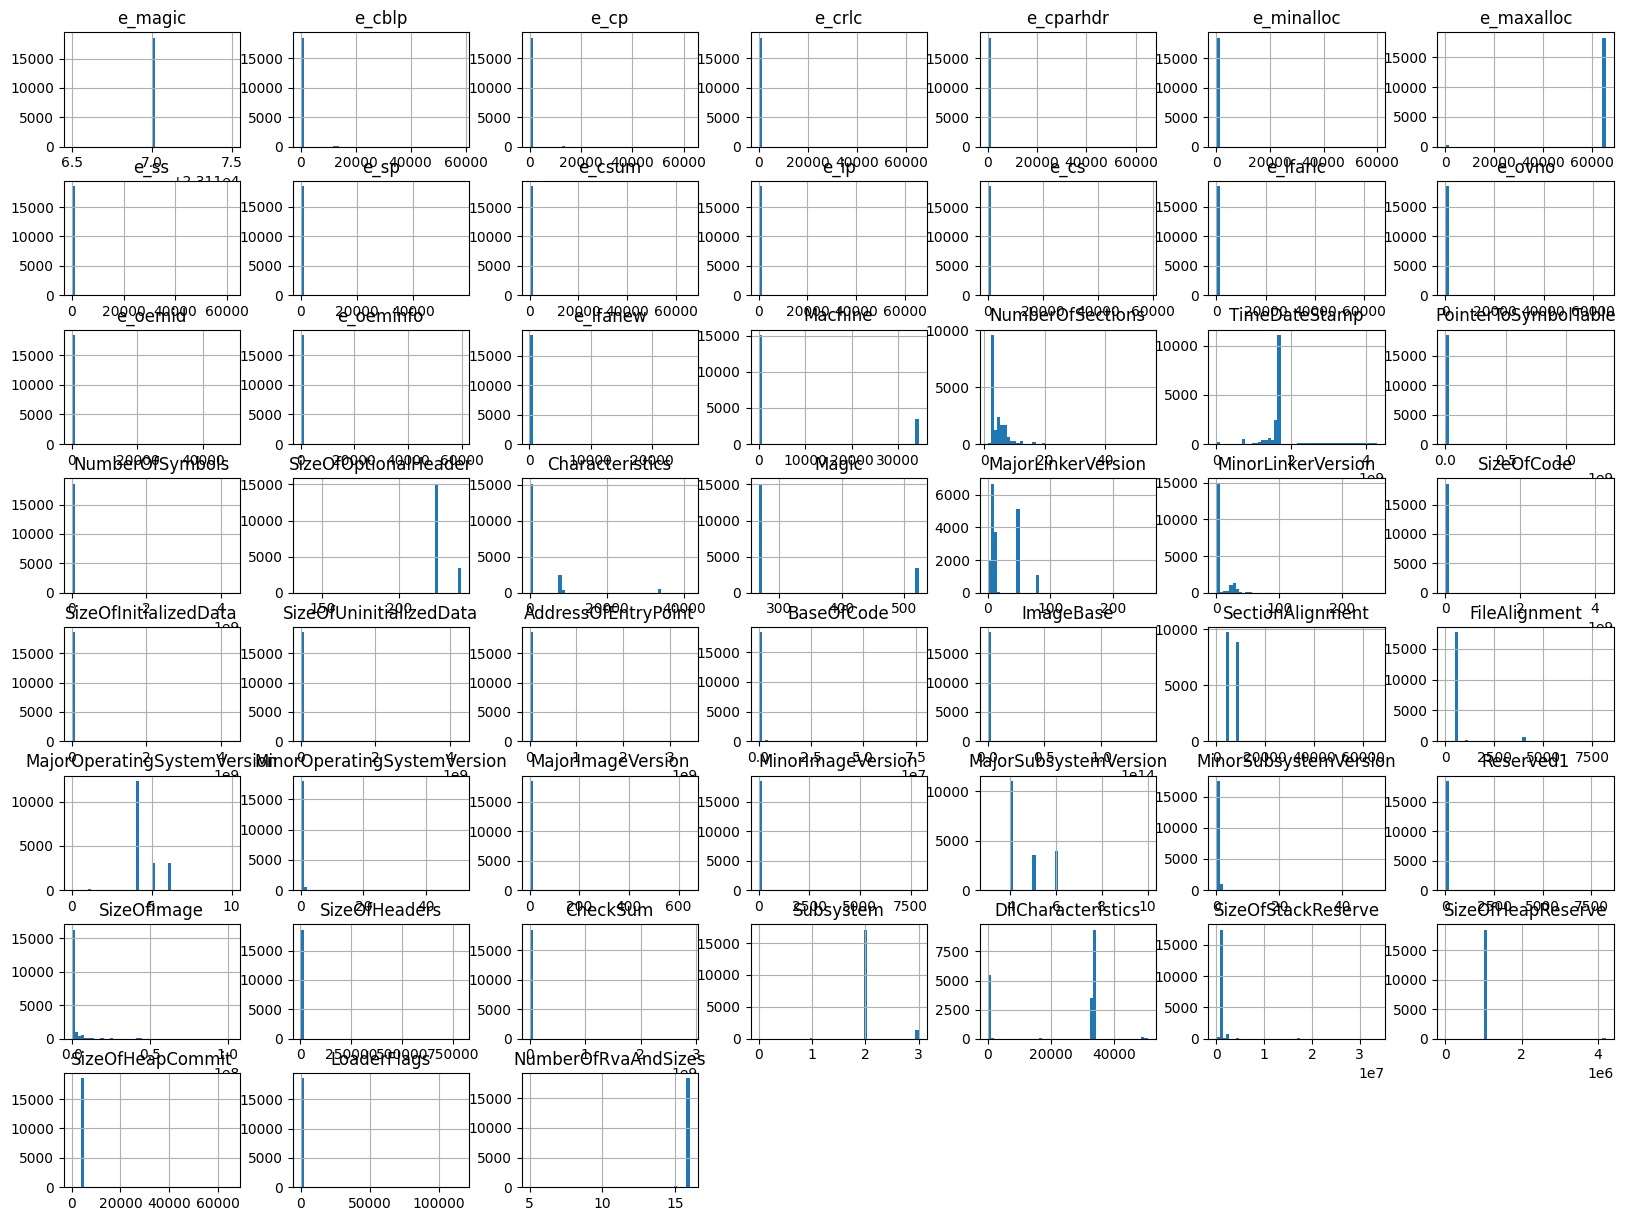

In [11]:
df.hist(bins=50, figsize=(20,15))

- Need to make sure there are no categorical columns hidding behind int numbers
- this could throw off the model predictions

In [3]:
for col in df.columns:
    unique_values = df[col].nunique()
    if unique_values < 20:
        print(col, unique_values, df[col].unique()[:10])
        

Malware_Type 5 ['Spyware' 'Generic Malware' 'Ransomware' 'Downloader' 'Backdoor']
e_magic 1 [23117]
e_cparhdr 19 [    4     0     2 33608 25815 33096   428    32     8 57225]
e_minalloc 17 [    0    15  8428    16 59828 26531   577    17 17746 33608]
e_maxalloc 13 [65535     0 33608  5194 17744 10120 35157  2539 15785 39921]
e_ss 18 [    0 61668     8 51504     7 18432 15024  1633     3 33253]
e_csum 17 [    0 28323     2 65514 42516 31086 22135   138 19456   145]
Machine 3 [  332 34404     0]
SizeOfOptionalHeader 3 [224 240 136]
Magic 2 [267 523]
SectionAlignment 5 [ 4096  8192 65536   512    16]
FileAlignment 6 [ 512 4096 1024 8192 2048   16]
MajorOperatingSystemVersion 10 [ 4  5  6 10  1  9  3  2  7  0]
MinorOperatingSystemVersion 6 [ 0  1  2  3  5 51]
MajorSubsystemVersion 6 [ 4  6  5 10  3  7]
MinorSubsystemVersion 6 [ 0  1  2 10  3 51]
Reserved1 3 [   0 8224 1423]
SizeOfHeaders 15 [  1024    512   4096   8192   2048   1536    696 786432   3584    584]
Subsystem 4 [3 2 1 0]
SizeOf

Since we are focused on ransomware only. I will turn combine the column Malware_Type to ransomware vs non-ransomware. For sakes of the project

Columns that need encoding:
* Malware_Type (target)
* Machine → has only 3 distinct IDs (device architectures)
* Subsystem → 4 system-type categories
* Possibly Magic, SizeOfOptionalHeader, LoaderFlags NumberOfRvaAndSizes    
    — these are fixed enums in PE headers, not continuous variables



In [4]:
#lets find skewed columns that could be feeding noise to the model
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Compute skewness
skew = df[numeric_cols].skew().sort_values(ascending=False)

# Identify columns with high positive or negative skew
skewed_cols = skew[abs(skew) > 1].index.tolist()

print(skewed_cols)

['LoaderFlags', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'Reserved1', 'PointerToSymbolTable', 'e_lfanew', 'SizeOfHeapCommit', 'ImageBase', 'MajorImageVersion', 'SizeOfHeaders', 'NumberOfSymbols', 'MinorImageVersion', 'SizeOfCode', 'SizeOfInitializedData', 'CheckSum', 'MinorOperatingSystemVersion', 'e_cparhdr', 'e_ip', 'e_ss', 'BaseOfCode', 'e_crlc', 'e_minalloc', 'e_csum', 'MinorSubsystemVersion', 'e_cs', 'e_cp', 'e_cblp', 'SizeOfStackReserve', 'SizeOfHeapReserve', 'e_lfarlc', 'e_sp', 'e_oemid', 'e_oeminfo', 'e_ovno', 'SizeOfImage', 'FileAlignment', 'Characteristics', 'NumberOfSections', 'Subsystem', 'MinorLinkerVersion', 'SectionAlignment', 'TimeDateStamp', 'Magic', 'Machine', 'SizeOfOptionalHeader', 'MajorOperatingSystemVersion', 'MajorLinkerVersion', 'e_maxalloc', 'NumberOfRvaAndSizes']


List shows nearly every numeric field is heavily skewed. Values like SizeOfImage, AddressOfEntryPoint, and SectionAlignment span several orders of magnitude.

log transform should only apply to continuous size-like fields, not categorical codes or small enums. Skip these:

* Machine, Subsystem, Magic, Characteristics (categorical/bitflags)
* Major*/Minor*Version and LinkerVersion (small bounded ints)

##### TRANSFORM EVERYTHING ELSE

In [50]:


#same function as preprocess - modified for this dataset

def preprocess(df):
    
    # ----- Turn Target to Ransomware vs Non-Ransomware
    # normalize everything to lower case before transforming
    vals = df['Malware_Type'].astype(str).str.lower()

    #match anything containing the keyword ransom
    is_ransomware = vals.str.contains('ransom', na=False)

    #new column - numeric labels 1/0
    df['Ransomware'] = is_ransomware.astype(int)

    #check
    print(df['Ransomware'].value_counts(dropna=False))#includes NaN

    #drop original target column
    df = df.drop(columns=['Malware_Type'])

    categorical_cols = [
        'Machine', 'Subsystem', 'Magic',
        'SizeOfOptionalHeader', 'LoaderFlags', 'NumberOfRvaAndSizes'
    ]
    
    #label encoding - replaces each category with an integer code(ok for tree)
    for col in categorical_cols:
        df[col] = df[col].astype('category').cat.codes
    
    # --- Drop Identifiers ---
    meta = df[['SHA256']].copy()
    df = df.drop(columns=['SHA256'])


    # drop highly correlated numeric columns only (needed for SVM)
    corr = df.select_dtypes(include=[np.number]).drop(columns=['Ransomware'], errors='ignore').corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop_cols = [c for c in upper.columns if any(upper[c] > 0.95)]

    df.drop(columns=drop_cols, inplace=True)

    #Mostly needed for linear models - so larger values dont dominate smaller ones
    log_cols = [
        'SizeOfImage', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData',
        'AddressOfEntryPoint', 'ImageBase', 'BaseOfCode', 'FileAlignment',
        'SectionAlignment', 'SizeOfStackReserve', 'SizeOfHeapReserve',
        'SizeOfHeapCommit', 'SizeOfHeaders', 'PointerToSymbolTable',
        'NumberOfSymbols', 'CheckSum', 'SizeOfOptionalHeader', 'TimeDateStamp'
    ]
    for col in log_cols:
        if col in df.columns:
            df[col] = np.log1p(df[col])

    # --- Split Features vs Target ---
    X = df.drop(columns=['Ransomware'])
    y = df['Ransomware']

    return X, y, meta


Dropped features ['SizeOfOptionalHeader', 'Magic']

In [51]:

X, y, meta = preprocess(df)



Ransomware
0    16175
1     2376
Name: count, dtype: int64


#### SMOTE - Synthetic Minority Over-sampling Technique 


- The current dataset is heavily imbalanced, the model learns to predict the majority class (its cheating)
- Applying SMOTE, we xan "fake" ransomware samples by using KNN model 
- Model will stop being lazy and actually analize


In [52]:

# now split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [12]:

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

#### ----- Random Forest ------

1. We find the best parameters for the random forest model. 
2. Once thats found and saved, we can run the model using the best_params

In [13]:
#Randomized search will sample random integers in the range given for the best  parameters 

param_dist = {'n_estimators': sp_randint(200, 1000),
    'max_depth': sp_randint(10, 60),
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 4)
}


#instance of Random forest model 
rf = RandomForestClassifier(random_state=42)

#Randomized search will sample random integers in the range given for the best  parameters 
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,               # number of random combinations to try
    cv=5,                    # 5-fold cross-validation
     scoring="matthews_corrcoef",
    verbose=2,
    random_state=42,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)
print(rf_random.best_score_)

#Based on randomized search -> best parameters:
rf_best = rf_random.best_estimator_ #trained model instance
y_pred = rf_best.predict(X_test)

print(rf_random.best_params_)




Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   3.7s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   3.9s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   4.0s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   4.1s
[CV] END max_depth=48, min_samples_leaf=1, min_samples_split=8, n_estimators=306; total time=   4.2s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=   8.7s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=   8.7s
[CV] END max_depth=17, min_samples_leaf=1, min_samples_split=6, n_estimators=814; total time=   8.7s
[CV] END max_depth=28, min_samples_leaf=3, min_samples_split=4, n_estimators=658; total time=   7.0s
[CV] END max_depth=28, min_sa

#### Random Forest Best Parameters

- {'max_depth': 24, 
- 'min_samples_leaf': 3, 
- 'min_samples_split': 3, 
- 'n_estimators': 753}




In [38]:
#run the model always using the best parameters

rf = RandomForestClassifier(n_estimators=753, 
                            max_depth=24,
                            min_samples_leaf=3,
                            min_samples_split=3,
                            random_state=42)

#

rf.fit(X_train, y_train)


#predict on test set

y_pred = rf.predict(X_test)

#Predictions on test data
print("\n--- Random Forest ---")
print(classification_report(y_test, y_pred, digits=3))
print(confusion_matrix(y_test, y_pred))



--- Random Forest ---
              precision    recall  f1-score   support

           0      0.873     0.998     0.931      6471
           1      0.480     0.013     0.025       950

    accuracy                          0.872      7421
   macro avg      0.677     0.505     0.478      7421
weighted avg      0.823     0.872     0.815      7421

[[6458   13]
 [ 938   12]]


465 ransomware samples → 10 correctly caught (≈ 2% recall).

3236 non-ransomware → almost all predicted correctly.

The weighted average F1 = 0.817 looks high only because non-ransomware dominates the dataset. The model’s basically saying “everything’s safe” and getting partial credit for it.

Next move is clear: balance the classes so the model actually learns the minority.

#### ----- XGBoost ----

In [53]:



xgb = XGBClassifier(
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train),  # balance weight
    random_state=42,
    eval_metric='logloss'  # suppresses warning
)

param_grid = {
   "n_estimators": [200, 500],
    "max_depth": [3, 5, 8],
    "learning_rate": [0.03, 0.1],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mcc_scorer = make_scorer(matthews_corrcoef)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=mcc_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Train and evaluate
grid.fit(X_train, y_train)

print("Best CV MCC: ", grid.best_score_)
print("Best parameters: ", grid.best_params_)

xgb_best = grid.best_estimator_

y_pred = xgb_best.predict(X_test)


print("\n--- XGBoost ---")
print(classification_report(y_test, y_pred, digits=3))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV MCC:  0.1729179233214481
Best parameters:  {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 200}

--- XGBoost ---
              precision    recall  f1-score   support

           0      0.913     0.627     0.743      3236
           1      0.189     0.592     0.286       475

    accuracy                          0.622      3711
   macro avg      0.551     0.609     0.515      3711
weighted avg      0.820     0.622     0.685      3711



In [59]:
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.03,
    scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train),  # balance weight
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'  # suppresses warning
)
# Train and evaluate
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(confusion_matrix(y_test, y_pred))



[[1885 1351]
 [ 169  306]]


In [55]:


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Malware', 'Ransomware']
)
fig, ax = plt.subplots(figsize=(5, 4)) #fig size

disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title("XGB Confusion Matrix", fontsize=12)
ax.set_xlabel("Predicted label", fontsize=11)
ax.set_ylabel("True label", fontsize=11)

plt.tight_layout()
plt.savefig("XGB_confusion_matrix_3.pdf")
plt.close()

In [31]:
mcc = matthews_corrcoef(y_test, y_pred)
print(f"{'MCC:':<20} {mcc:.3f}")


MCC:                 0.160


Best Parameters when using:

 - SMOTE + no scale:
MCC:0.081 Best parameters:  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500}
- Scale + NO SMOTE + make_scorer
MCC:0.160 Best parameters:  {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 200}



Cross-val MCC mean: 0.1076826877733255


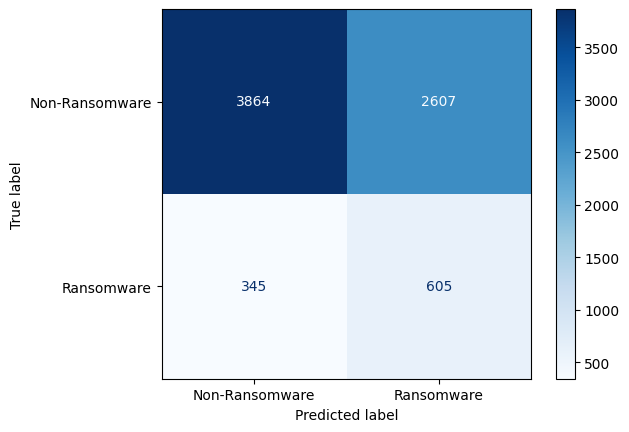

In [21]:
#make matrix more readable
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Non-Ransomware', 'Ransomware']
)
disp.plot(cmap='Blues', values_format='d')

scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='matthews_corrcoef')
print("Cross-val MCC mean:", scores.mean())


Best parameters:  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}

* Best CV MCC (With Smote): 0.4936168388910115
* Best CV MCC (Without Smote): 0.16454034760671765
-> When SMOTE IS NOT applied scale_pos_weight is used





Interpretation:

Class 0 (non-ransomware) recall = 0.995 → nearly perfect.

Class 1 (ransomware) recall = 0.015 → almost none detected.

-> because the dataset is unbalanced the model has learned it has better chance of getting the correct answer if it says nothing is ransomware. Have to get back to the root

##### ------- SVM ------

In [56]:
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, StratifiedKFold


fast_svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(
        dual=False,
        max_iter=20000,
        tol=1e-3,
        class_weight="balanced"
    ))
])

param_grid = {
    "svm__C": [0.001, 0.01, 0.1, 1, 10, 100]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mcc_scorer = make_scorer(matthews_corrcoef)

svm_search = GridSearchCV(
    estimator=fast_svm_pipe,
    param_grid=param_grid,
    scoring=mcc_scorer,
    cv=cv,
    n_jobs=-1
)

svm_search.fit(X_train, y_train)

print("Best params:", svm_search.best_params_)
print("Best CV MCC:", svm_search.best_score_)

Best params: {'svm__C': 0.001}
Best CV MCC: 0.16393296356409387


In [57]:
y_pred = svm_search.predict(X_test)


### Dataset 3 – Linear SVM (Baseline, No SMOTE)

Baseline run on Dataset 3 (ransomware vs. other malware) using a linear SVM  
with a small grid search over `C` (5 iterations).

**Initial run**
- `C = 0.01`
- Test MCC ≈ **0.156**
- Decent recall for ransomware, but very low precision
- Model flags many malware samples as ransomware

**Cross-validation results**
- Best `C = 0.001`
- Best CV MCC ≈ **0.157**

**Final evaluation with best `C`**
- Test MCC ≈ **0.169**
- Ransomware recall increased slightly
- Precision remains low → lots of false positives
- Overall accuracy drops, but MCC improves

Takeaway: performance changes are small but consistent.  
Static PE-header features provide a weak signal for this task, even with tuning.  
This run serves as the pre-SMOTE baseline for Dataset 3.






### Dataset 3 – Linear SVM (With SMOTE)

This run evaluates the same linear SVM setup on Dataset 3 after applying SMOTE  
to address class imbalance.

**Cross-validation results**
- Best `C = 0.1`
- Best CV MCC ≈ **0.254**
- CV performance improves noticeably after resampling

**Test set performance (with SMOTE)**

- Test MCC ≈ **0.157**
- Test metrics are nearly unchanged compared to the no-SMOTE baseline
- Minority class recall remains high, but precision is still very low
- Accuracy and weighted F1 show minimal movement

**Takeaway**
SMOTE improves cross-validation performance but does not translate to meaningful
gains on the held-out test set. This suggests that class imbalance is not the
primary bottleneck for Dataset 3; instead, the limitation comes from feature
overlap between ransomware and other malware when using static PE-header features.



In [58]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Malware', 'Ransomware']
)
fig, ax = plt.subplots(figsize=(5, 4)) #fig size

disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title("SVM Confusion Matrix", fontsize=12)
ax.set_xlabel("Predicted label", fontsize=11)
ax.set_ylabel("True label", fontsize=11)

plt.tight_layout()
plt.savefig("SVM_confusion_matrix_3.pdf")
plt.close()

In [11]:

# 1. Use the best model found by the search to make predictions
from sklearn.metrics import matthews_corrcoef


y_pred = svm_search.predict(X_test)

# 2. Generate the report
# We use digits=3 because Reviewer 10 requested "rigorous, professional discussion"
report = classification_report(y_test, y_pred, digits=3)

print("--- SVM Final Performance (Best Params) ---")
print(report)

mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.3f}")


--- SVM Final Performance (Best Params) ---
              precision    recall  f1-score   support

           0      0.920     0.575     0.708      6471
           1      0.185     0.659     0.289       950

    accuracy                          0.586      7421
   macro avg      0.553     0.617     0.499      7421
weighted avg      0.826     0.586     0.654      7421

Matthews Correlation Coefficient (MCC): 0.157


* Dataset 3 performance remained weak after convergence fixes, indicating that the limitation stems from feature overlap rather than optimization issues. 
* Static PE-header features provide insufficient separation between ransomware and other malware for linear SVMs.

### Using **SHAP** 

- Since single features are not deterministic, SHAP will help us understand which **combination** of features drives the models to make preditions
- We will also be able to see relationships that simple correlation methods can miss

In [60]:
bool_cols = X.select_dtypes('bool').columns

X_fixed = X.copy()

for col in bool_cols:
    X_fixed[col] = X_fixed[col].astype(int)

X_fixed.dtypes

e_magic                          int64
e_cblp                           int64
e_cp                             int64
e_crlc                           int64
e_cparhdr                        int64
e_minalloc                       int64
e_maxalloc                       int64
e_ss                             int64
e_sp                             int64
e_csum                           int64
e_ip                             int64
e_cs                             int64
e_lfarlc                         int64
e_ovno                           int64
e_oemid                          int64
e_oeminfo                        int64
e_lfanew                         int64
Machine                           int8
NumberOfSections                 int64
TimeDateStamp                  float64
PointerToSymbolTable           float64
NumberOfSymbols                float64
Characteristics                  int64
MajorLinkerVersion               int64
MinorLinkerVersion               int64
SizeOfCode               

In [61]:
import shap


# Reorder and align columns to the model’s training schema
X_aligned = X_fixed[xgb.feature_names_in_]

# Sample subset for SHAP
background = X_aligned.sample(n=200, random_state=42)
X_sample = X_aligned.sample(n=500, random_state=42)

# Run SHAP again
explainer = shap.Explainer(xgb, background)
shap_values = explainer(X_sample, check_additivity=False)

# Select SHAP values for class 1 (Malware)
shap_values_malware = shap_values
#check to comfirm which class SHAP is predicting (have to select 0 or 1 for ransom or benign)
print(shap_values.shape)
print(X_sample.shape)

(500, 50)
(500, 50)


In [62]:
# Plot feature importance for ransomware predictions
plt.figure(figsize=(7,4))
shap.plots.bar(shap_values_malware, show=False)
plt.tight_layout()
plt.savefig("shap_bar_XGB_3.pdf", format="pdf", bbox_inches="tight")
plt.close()

plt.figure(figsize=(7,6))
shap.plots.beeswarm(shap_values_malware, show=False)
plt.tight_layout()
plt.savefig("shap_bee_XGB_3.pdf", format="pdf", bbox_inches="tight")
plt.close()


### SHAP Feature Importance — Ransomware vs. Malware Dataset

This SHAP summary plot represents the **top structural features** influencing predictions when distinguishing **ransomware** from **other malware families**.  
Unlike the benign-vs-ransomware dataset, here both classes share malicious characteristics, making their binary patterns far more similar and reducing model separability.

---

#### Overview
The model attempts to detect subtle **code-level and compilation differences** between ransomware and generic malware samples.  
Because both types are malicious executables, they share many overlapping behaviors — causing weaker overall signal strength and inconsistent accuracy across models.

---

#### Top Influential Features

| Rank | Feature | Description | Interpretation |
|------|----------|--------------|----------------|
| **1** | `DllCharacteristics` | Flags describing security and DLL-loading properties | Continues to dominate as a key signal. Specific flag patterns (e.g., ASLR, DEP, or dynamic linking settings) differ slightly between ransomware and other malware families. |
| **2** | `TimeDateStamp` | Timestamp of when the PE file was compiled | Compilation timestamps provide temporal patterns — ransomware often exhibits clustered or spoofed build times. |
| **3** | `AddressOfEntryPoint` | Memory address where execution begins | Reflects how code sections are arranged; ransomware may use custom entry points for encryption routines. |
| **4** | `SizeOfInitializedData` | Amount of pre-initialized global/static data | Large data sections can indicate embedded keys, encrypted blobs, or ransom notes. |
| **5** | `SizeOfImage` | Total size of the PE image in memory | Slightly elevated for ransomware, which may pack additional payloads. |
| **6** | `SizeOfCode` | Size of executable code section | Moderate influence; ransomware variants sometimes have compressed or obfuscated code sections. |
| **7** | `MajorLinkerVersion` | Version of the linker used | Weaker influence; indicates minor toolchain differences among malware families. |
| **8** | `SectionAlignment` | Alignment of PE sections in memory | May reflect packing or encryption tools used during ransomware compilation. |
| **9** | `CheckSum` | Optional checksum field | Occasionally manipulated or omitted in ransomware binaries. |
| **10** | `Sum of 41 other features` | Combined weaker influences | The model distributes remaining importance across many minor features, suggesting no single dominant ransomware trait. |

---

#### Interpretation Summary
- **DllCharacteristics** remains the strongest signal, reinforcing that DLL and loader behaviors are crucial across malware detection tasks.  
- The next most important attributes (`TimeDateStamp`, `AddressOfEntryPoint`, `SizeOfInitializedData`) describe **compilation structure**, not runtime behavior.  
- These static PE header fields vary within malware families but not enough to create a clear boundary between ransomware and other malware — explaining the model’s **reduced accuracy and generalization difficulty**.

---

#### Conclusion
The SHAP analysis confirms that **structural similarity** between ransomware and generic malware limits the discriminative power of static PE-header features.  
While features like DLL characteristics and compilation timestamps provide some separation, they lack the distinctiveness seen in benign comparisons.  
Future improvement would require incorporating **behavioral or dynamic features** (e.g., API call sequences, encryption routines, or system event logs) to better capture ransomware-specific traits.


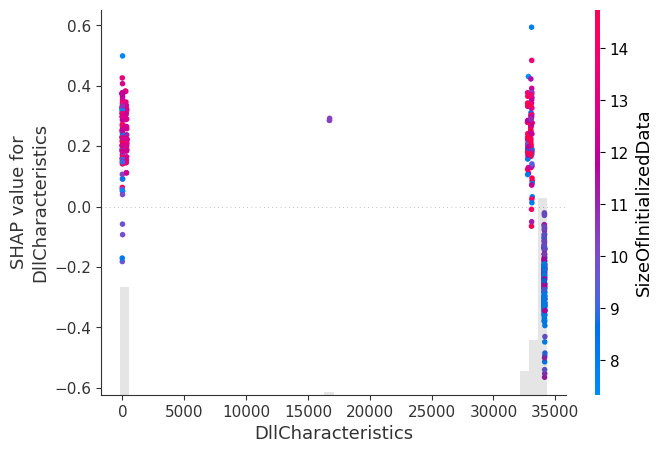

In [13]:
shap.plots.scatter(shap_values[:, "DllCharacteristics"], color=shap_values)

### SHAP Dependence Analysis — `DllCharacteristics` (Ransomware vs. Malware)

This SHAP dependence plot visualizes how the **`DllCharacteristics`** feature influences the model’s prediction of **ransomware** within the ransomware–vs–malware dataset.  
Color represents **`SizeOfInitializedData`**, another feature interacting with `DllCharacteristics`.

---
#### Interpretation of Axes
- **X-axis:** Raw values of `DllCharacteristics` (PE header flags related to DLL behavior).  
- **Y-axis:** SHAP values, showing the strength and direction of influence on predicting ransomware.  
  - **Positive SHAP value →** pushes prediction toward *ransomware*  
  - **Negative SHAP value →** pushes prediction toward *non-ransomware malware*  
- **Color scale:** Represents the interacting feature `SizeOfInitializedData`.

---

#### Observations

1. **Two main clusters (near 0 and ~35,000)**  
   - The model sees two dominant patterns in `DllCharacteristics`.  
   - Both ransomware and other malware occupy similar DLL flag ranges, showing overlapping distributions.  
   - This overlap explains why the model finds it hard to separate the two classes.

2. **Low `DllCharacteristics` values (near 0)**  
   - Often correspond to **positive SHAP values**, meaning these samples lean more toward *ransomware*.  
   - Indicates that missing or minimal DLL security flags are slightly more common in ransomware binaries.

3. **High `DllCharacteristics` values (~30,000–35,000)**  
   - Produce both positive and negative SHAP values, suggesting **no consistent direction** of influence.  
   - Some ransomware and non-ransomware samples share identical flag patterns.

4. **Interaction with `SizeOfInitializedData`**  
   - Color variations show that samples with **larger initialized data sections** (pink/red points) tend to have slightly stronger positive SHAP values.  
   - Suggests ransomware may use more initialized data (e.g., static keys or encrypted strings), but the effect is subtle.

---

#### Summary

> The `DllCharacteristics` feature has **limited discriminatory power** between ransomware and other malware families.  
> While lower values (missing DLL protection flags) slightly increase ransomware likelihood, the overall overlap in DLL configurations between malware types weakens its predictive strength.  
> The interaction with `SizeOfInitializedData` hints at mild structural differences, but not enough to provide clear class separation — reinforcing why the model’s performance dropped on this dataset.
